In [17]:
from mpdaf.obj import Image, WCS, Cube
import numpy as np

from astropy import units as u

import matplotlib.pyplot as plt
from plotbin import plot_velfield
from mgefit.find_galaxy import find_galaxy

In [36]:
cube = Cube("/home/carlos/Documents/GitHub/Master-Degree/SDP81/Dynamics/pPXF/Data/Cut.fits")

[INFO] 60 x 60 Image (/home/carlos/Documents/GitHub/Master-Degree/SDP81/Dynamics/pPXF/Data/Cut.fits)
[INFO] .data(60 x 60) (1e-20 erg / (Angstrom cm2 s)), .var(60 x 60)
[INFO] center:(00:39:07.0985,09:03:11.6099) size:(12.000",12.000") step:(0.200",0.200") rot:-0.0 deg frame:FK5


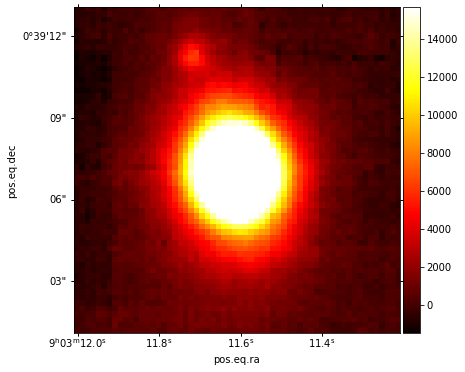

In [37]:
#Plot image of data cube, only for check
img = cube.sum(axis=0)
plt.figure(figsize=(8,6))
img.plot(use_wcs=True,zscale=True, cmap="hot", colorbar="v")
img.info()

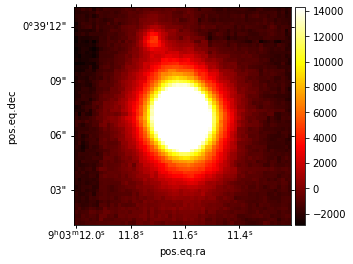

In [38]:
#Proporties of the image

minlevel = 7000   #counts/px
sky = img.background()[0]         #counts/px
scale = 0.2      #arcsec/pxz
img = img - sky

img.plot(use_wcs=True,zscale=True, cmap="hot", colorbar="v")

 Pixels used: 711
 Peak Img[j, k]: 29 29
 Mean (j, k): 28.89 29.29
 Theta (deg): 78.1
 Astro PA (deg): 11.9
 Eps: 0.182
 Major axis (pix): 17.3


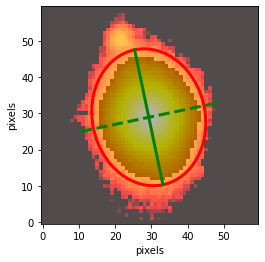

In [39]:
f = find_galaxy(img.data.data, fraction=0.2, plot=1)

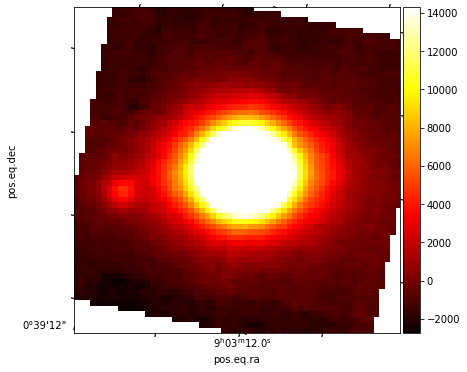

In [40]:
plt.figure(figsize=(8,6))
rot_img = img.rotate(90-11.6)
rot_img.plot(use_wcs=True,zscale=True, cmap="hot", colorbar="v")

In [42]:
img.wcs.pix2sky(np.array([29,29]))

array([[  0.65194403, 135.79840253]])

In [5]:
x = []
y = []
z = []

for i in range(60): #x
    for j in range(60):#y
        x.append(i)
        y.append(j)
        z.append(img.data.data[j,i])

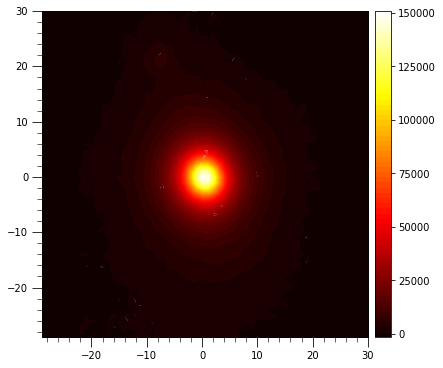

In [42]:
x = np.array(x)-29
y = np.array(y)-29
z = np.array(z)

plt.figure(figsize=(8,6))
plot_velfield.plot_velfield(x,y,z, nodots=True, cmap="hot", colorbar=True)

In [43]:
def rotate_points(x, y, ang):
    """
    Rotates points conter-clockwise by an angle ANG in degrees.
    Michele cappellari, Paranal, 10 November 2013

    """
    theta = np.radians(ang)
    xNew = x*np.cos(theta) - y*np.sin(theta)
    yNew = x*np.sin(theta) + y*np.cos(theta)

    return xNew, yNew  

In [44]:
xnew, ynew = rotate_points(x,y, 90-11.6)

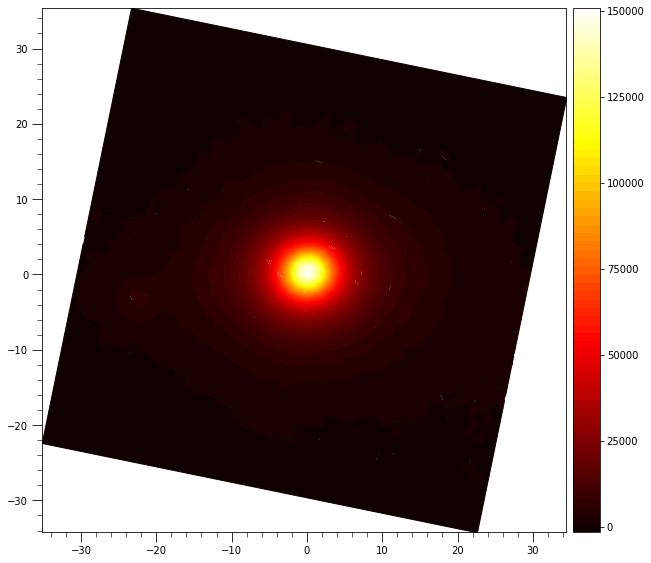

In [45]:
plt.figure(figsize=(10,10))
plot_velfield.plot_velfield(xnew,ynew,z, nodots=True, cmap="hot", colorbar=True)

In [55]:
rell = 0.2 * np.sqrt(xnew**2 + (ynew/(1-0.234))**2)
rell_tag = np.empty_like(rell)

In [56]:
dx = 0
tag = 0
while dx < rell.max():
    for i in range(rell.size):
        if dx <= rell[i] < dx+0.2:
            rell_tag[i] = tag
    tag = tag + 1
    dx = dx + 0.2
    
    

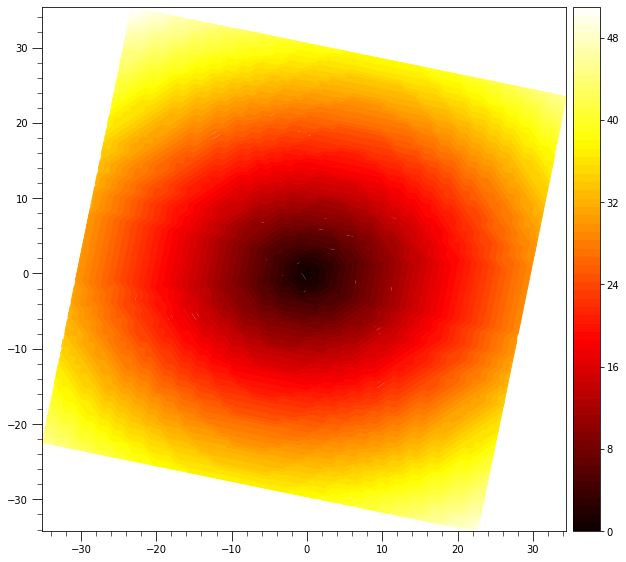

In [57]:
plt.figure(figsize=(10,10))
plot_velfield.plot_velfield(xnew,ynew,rell_tag, nodots=True, cmap="hot", colorbar=True)

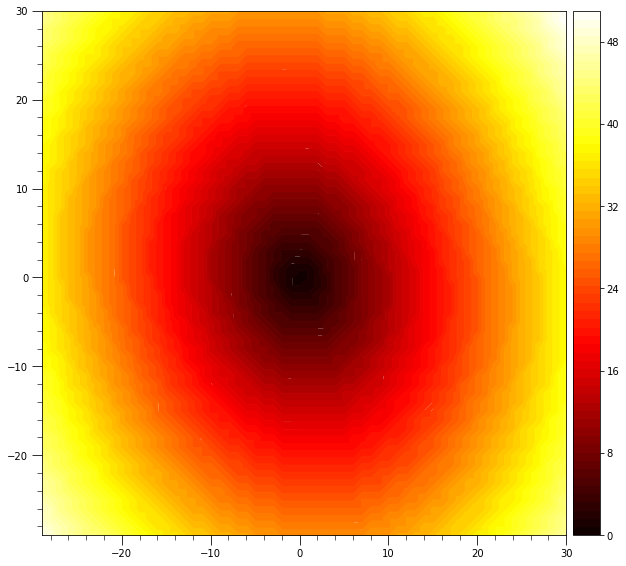

In [58]:
plt.figure(figsize=(10,10))
plot_velfield.plot_velfield(x,y,rell_tag, nodots=True, cmap="hot", colorbar=True)

In [114]:
dx = 0.0
tag = 0
while dx < rell.max():
    for ypx in range(60):
        for xpx in range(60):
            rot_x, rot_y = rotate_points(xpx-f.xpeak,ypx-f.ypeak, 90-f.pa)
            r =  0.2 * np.sqrt(rot_x**2 + (rot_y/(1-f.eps))**2)
            if dx <= r < dx + 0.2:
                img.data.data[ypx,xpx] =  tag
                if r >= f.majoraxis*0.2:
                    img.data.data[ypx,xpx] =  np.nan
    dx = dx + 0.2
    tag = tag + 1
                
        

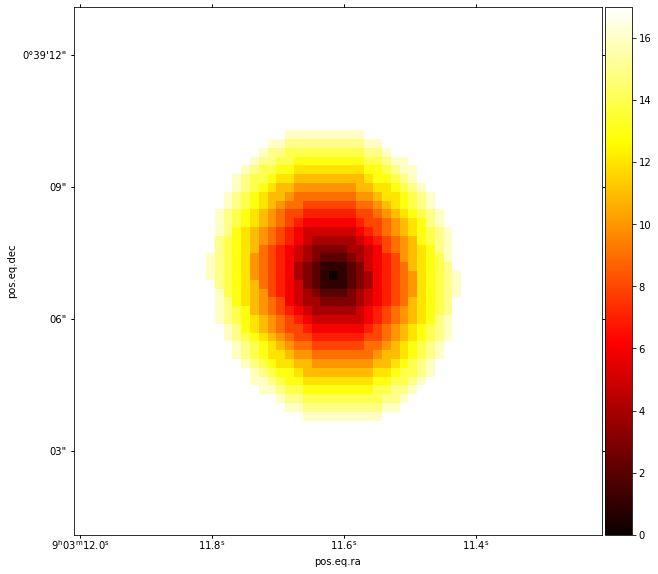

In [115]:
plt.figure(figsize=(10,10))
img.plot(colorbar='v', cmap="hot", use_wcs=True)

img.write("Img_tag.fits")

In [116]:
snr = np.loadtxt('/home/carlos/Documents/GitHub/Master-Degree/SDP81/Dynamics/pPXF/Codes/SNR.txt')

In [117]:
x = []
y = []
signal = []
noise = []
for i in range(len(snr)):
    if snr[i][4]/snr[i][5] > 1.0:
        x.append(snr[i][1])
        y.append(snr[i][0])
        signal.append(snr[i][4])
        noise.append(snr[i][5])

print(len(signal))

550


In [118]:
np.savetxt('GoodPixels.txt',np.column_stack([y, x, signal, noise]), header='y_px x_px signal noise')

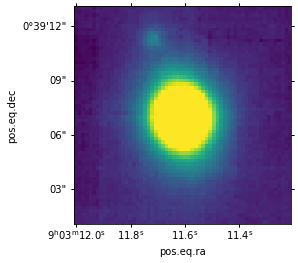

In [121]:
from mpdaf.obj import Cube
cube = Cube("/home/carlos/Documents/GitHub/Master-Degree/SDP81/Dynamics/pPXF/Data/Cut.fits") #Load cut data cube
#Plot image of data cube, only for check
img = cube.sum(axis=0)
img.plot(use_wcs=True,zscale=True)

In [122]:
y, x, signal, noise = np.loadtxt("GoodPixels.txt", unpack=True) #Read the table with pixel above snr = 2

In [126]:
img.data.data[:] = 0                                  #For all pixel in the image we atribute zero

for i in range(len(y)):                               #For pixels above the threshold we give its signal
    img.data.data[int(y[i])][int(x[i])] = signal[i]/noise[i]

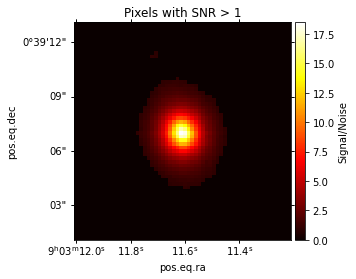

In [127]:
#Plot and save result

plot = img.plot(use_wcs=True, cmap='hot', colorbar='v', title="Pixels with SNR > 1")
plot.colorbar.set_label('Signal/Noise')
plt.savefig("GoodPixels.png",format='png')

In [128]:
img.write("SNR_map.fits")

In [129]:
from os import path
import numpy as np
import matplotlib.pyplot as plt

import vorbin
from vorbin.voronoi_2d_binning import voronoi_2d_binning

Bin-accretion...
1  /  14
2  /  14
3  /  14
4  /  14
5  /  14
6  /  14
7  /  14
8  /  14
9  /  14
10  /  14
11  /  14
12  /  14
13  /  14
14  /  14
15  /  14
16  /  14
17  /  14
18  /  14
19  /  14
19  initial bins.
Reassign bad bins...
12  good bins.
Unbinned pixels:  0  /  550
Fractional S/N scatter (%): 43.18238128518648
Elapsed time accretion: 0.07 seconds
Elapsed time optimization: 0.00 seconds


'\nnp.savetxt(\'Voronoi_OutPut.txt\', np.column_stack([y, x, binNum]),header="y_px \t x_px \t Vorbin_Id", fmt=b\'%10.6f %10.6f %8i\')\nplt.subplot(211)\nplt.xlabel(\'R(px)\')\nplt.ylabel(\'R(px)\')\nplt.subplot(212)\nplt.xlabel(\'R(px)\')\nplt.savefig(\'Vorbin.png\', format=\'png\')\n'

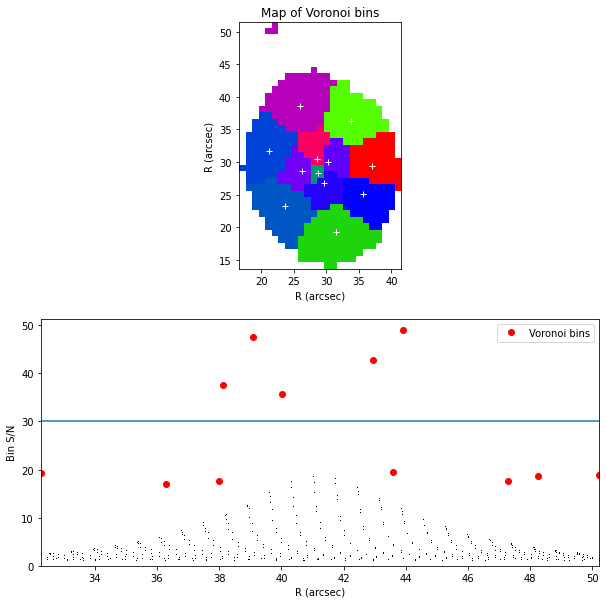

In [146]:
#y: é a posição y de onde foi extraído o sinal e o ruído
#x: é a posição x de onde foi extraído o sinal e o ruído
#signal: é o sinal do spaxel (y,x)
#noise: é o ruído do spaxel (y,x)

y, x, signal, noise = np.loadtxt("GoodPixels.txt").T #Lê a saída do código SNR
targetSN = 30 #Threshold pretendido

    # Perform the actual computation. The vectors
    # (binNum, xNode, yNode, xBar, yBar, sn, nPixels, scale)
    # are all generated in *output*
    #
plt.figure(figsize=(10,10))
binNum, xNode, yNode, xBar, yBar, sn, nPixels, scale = voronoi_2d_binning(x, y, signal, 
                                                                          noise, targetSN, plot=1, quiet=0, wvt=False, cvt=False)

    # Save to a text file the initial coordinates of each pixel together
    # with the corresponding bin number computed by this procedure.
    # binNum uniquely specifies the bins and for this reason it is the only
    # number required for any subsequent calculation on the bins.
    #
'''
np.savetxt('Voronoi_OutPut.txt', np.column_stack([y, x, binNum]),header="y_px \t x_px \t Vorbin_Id", fmt=b'%10.6f %10.6f %8i')
plt.subplot(211)
plt.xlabel('R(px)')
plt.ylabel('R(px)')
plt.subplot(212)
plt.xlabel('R(px)')
plt.savefig('Vorbin.png', format='png')
'''
#Essas são as novas posições dos spaxels binnados

#print(xBar)
#print(yBar)

In [143]:
help(voronoi_2d_binning)

Help on function voronoi_2d_binning in module vorbin.voronoi_2d_binning:

voronoi_2d_binning(x, y, signal, noise, targetSN, cvt=True, pixelsize=None, plot=True, quiet=True, sn_func=None, wvt=True)
    VorBin Purpose
    --------------
    
    Perform adaptive spatial binning of two-dimensional data
    to reach a chosen constant signal-to-noise ratio per bin.
    This program implements the algorithm described in section 5.1 of
    `Cappellari & Copin (2003) <http://adsabs.harvard.edu/abs/2003MNRAS.342..345C>`_
    
    Calling Sequence
    ----------------
    
    .. code-block:: python
    
        binNum, xBin, yBin, xBar, yBar, sn, nPixels, scale =             voronoi_2d_binning(x, y, signal, noise, targetSN,
                               cvt=True, pixelsize=None, plot=True,
                               quiet=True, sn_func=None, wvt=True)
    
    
    Input Parameters
    ----------------
    
    x:
        Vector containing the X coordinate of the pixels to bin.
        Arb